In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import Solve
from sos4hjb.optimization import SosProgram
from sos4hjb.polynomials import Variable, MonomialVector, ChebyshevVector, Polynomial, level_plot

%matplotlib notebook

# System dynamics

In [2]:
# State with limits.
x = Variable.multivariate('x', 2)
xlim = np.array([1, 1])
xobj = xlim / 3
x_m = [MonomialVector.make_polynomial(xi) for xi in x]
xlim_m = [MonomialVector.make_polynomial(xlimi) for xlimi in xlim]
X = [(xi + xlimi) * (xlimi - xi) for xi, xlimi in zip(x_m, xlim_m)]

# Input with limits.
u = Variable('u')
ulim = 1
u_m = MonomialVector.make_polynomial(u)
ulim_m = MonomialVector.make_polynomial(ulim)
U = (u_m + ulim_m) * (ulim_m - u_m)

# Dynamics.
fx = [
    2 * x_m[0] ** 3 + x_m[0] ** 2 * x_m[1] - 6 * x_m[0] * x_m[1] ** 2 + 5 * x_m[1] ** 3,
    MonomialVector.make_polynomial(0)
]
fu = [
    MonomialVector.make_polynomial(0),
    MonomialVector.make_polynomial(1)
]
f = [fx[i] + fu[i] * u_m for i in range(2)]

# Running cost.
lx = x_m[0] ** 2 + x_m[1] ** 2
lu = 5 * u_m ** 2
l = lx + lu

# Lower bound on the value function (monomial basis)

In [3]:
def value_function_lb(f, l, X, U, degree):

    # Set up SOS program.
    prog = SosProgram()
    vector_type = type(f[0].vectors()[0])
    basis = vector_type.construct_basis(x, degree, odd=False)
    J = prog.NewFreePolynomial(basis)[0]

    # Maximize volume beneath the value function.
    Jint = J.definite_integral(x, - xobj, xobj)
    prog.AddLinearCost(- Jint.to_scalar())

    # S-procedure for the state limits.
    basis = vector_type.construct_basis(x + [u], degree // 2)
    Sprocedure = Polynomial({})
    for Xi in X:
        lamxi = prog.NewEvenDegreeSosPolynomial(basis)[0]
        Sprocedure += lamxi * Xi

    # S-procedure for the input limits.
    lamu = prog.NewEvenDegreeSosPolynomial(basis)[0]
    Sprocedure += lamu * U

    # Bellman inequality.
    Jdot = sum(J.derivative(xi) * f[i] for i, xi in enumerate(x))
    prog.AddSosConstraint(Jdot + l - Sprocedure)

    # Value function nonpositive in the origin.
    prog.AddLinearConstraint(J({xi: 0 for xi in x}) <= 0)

    # Solve and retrieve result.
    result = Solve(prog)
    Jlb = prog.evaluate_at_optimum(J, result)
    obj = - result.get_optimal_cost()

    return Jlb, obj

In [4]:
# Solve for increasing degree.
degrees = [2, 4, 6, 8, 10, 12]
Jmon = {}
for d in degrees:
    print(f'Working on SOS of degree {d}', end='\r')
    Jmon[d] = value_function_lb(f, l, X, U, d)

<IPython.core.display.Javascript object>


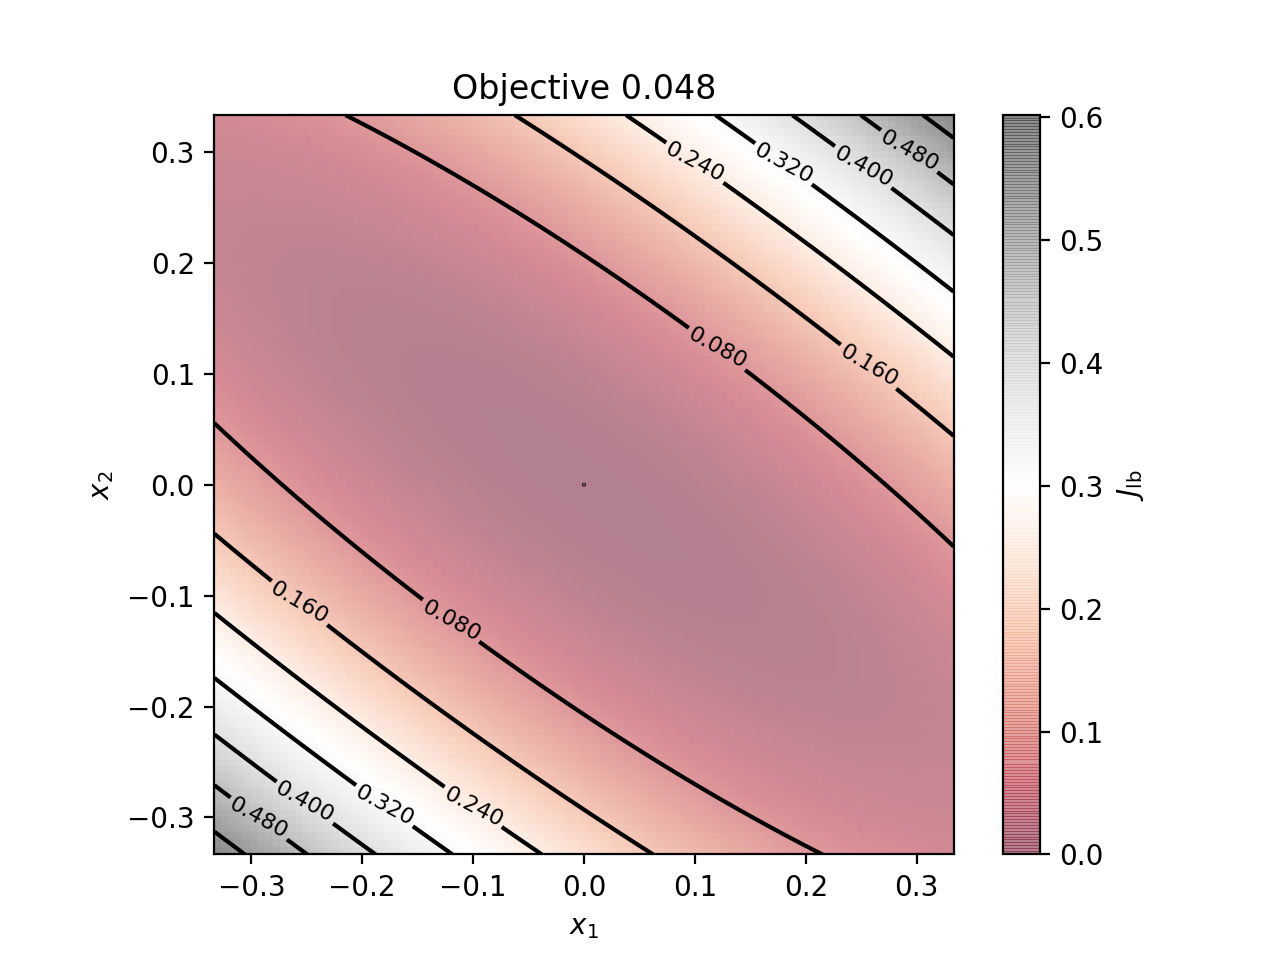

<IPython.core.display.Javascript object>


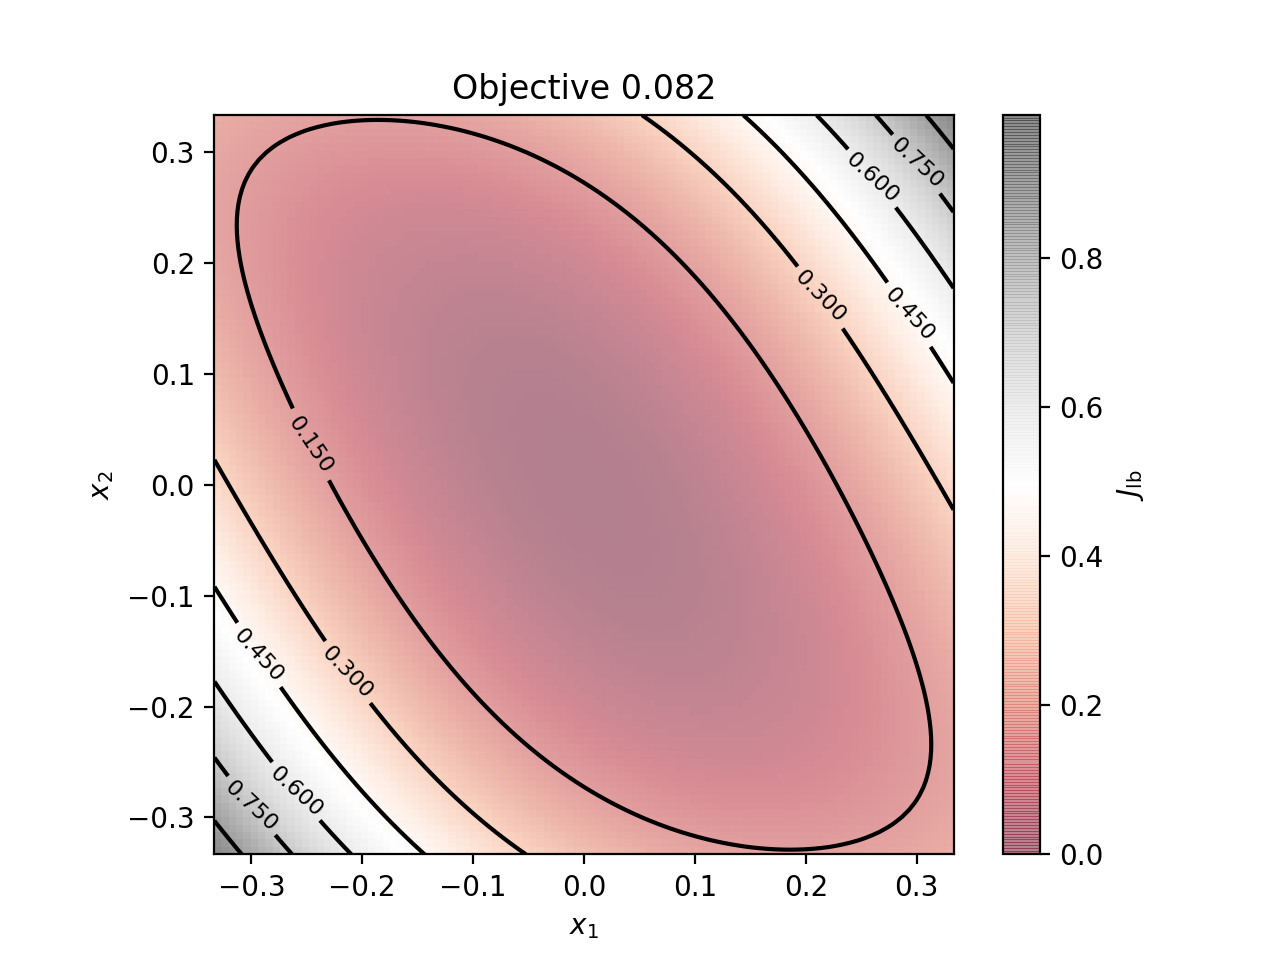

<IPython.core.display.Javascript object>


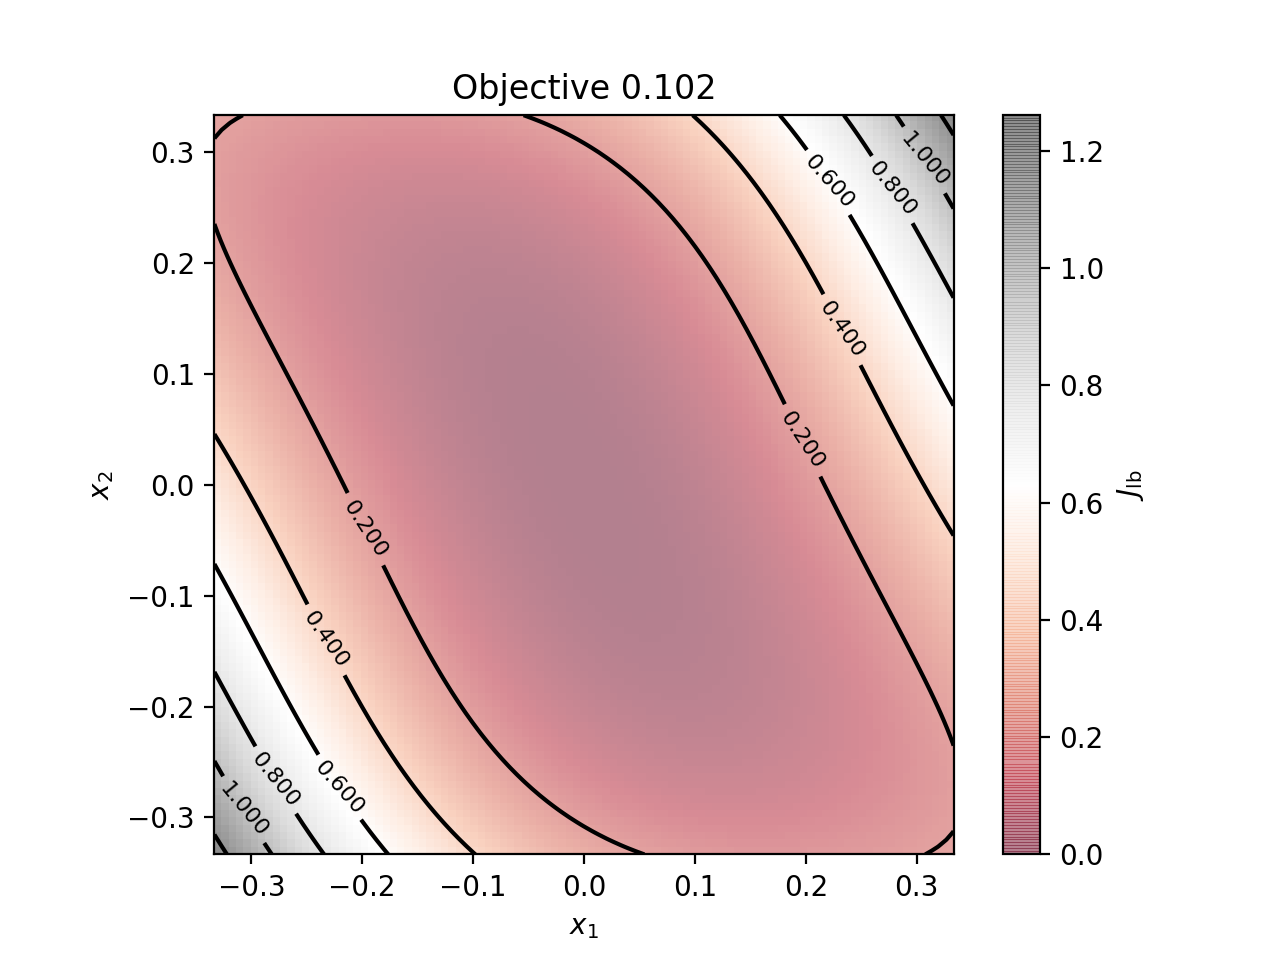

<IPython.core.display.Javascript object>


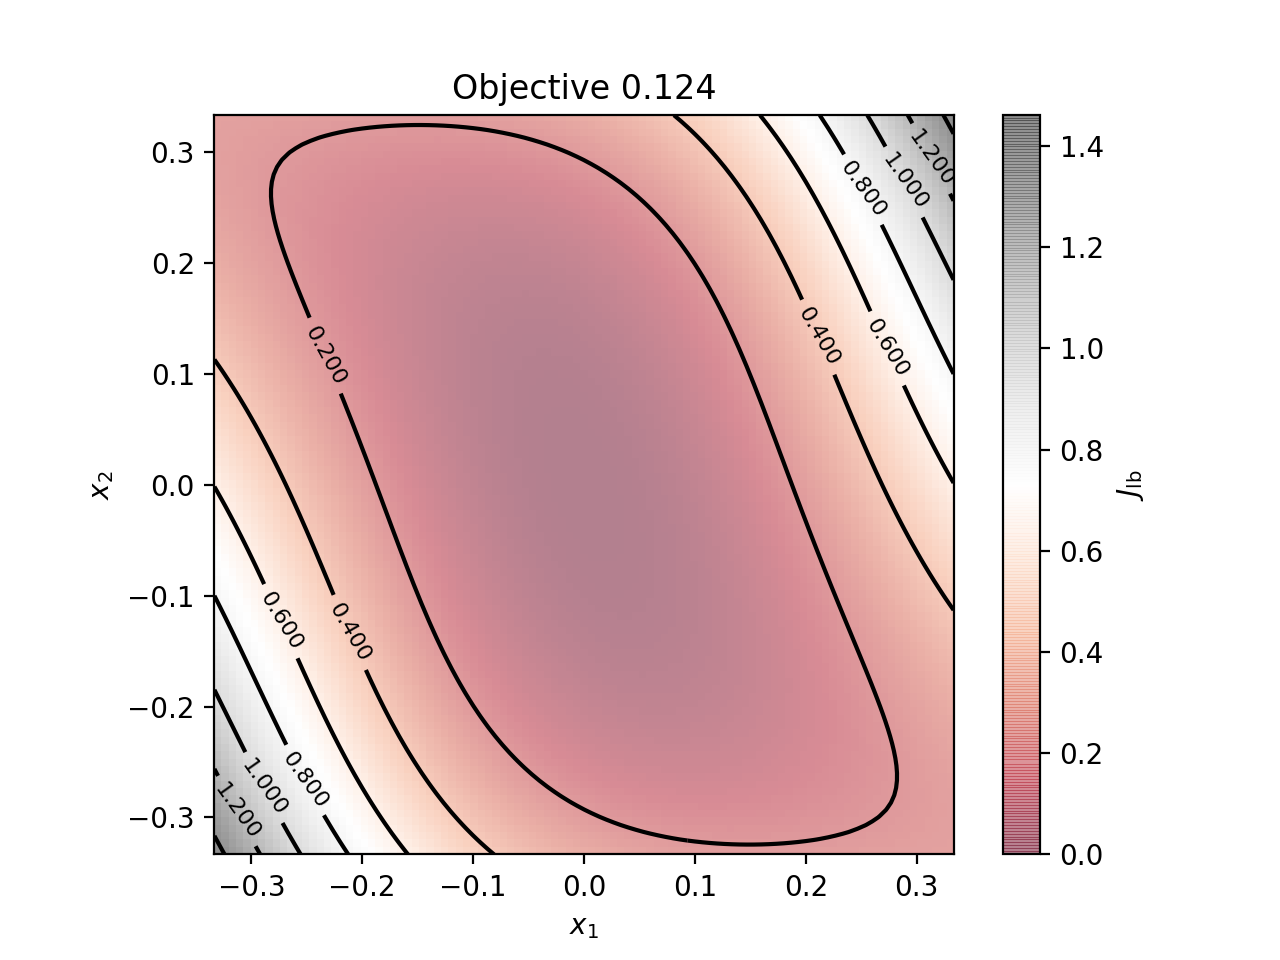

<IPython.core.display.Javascript object>


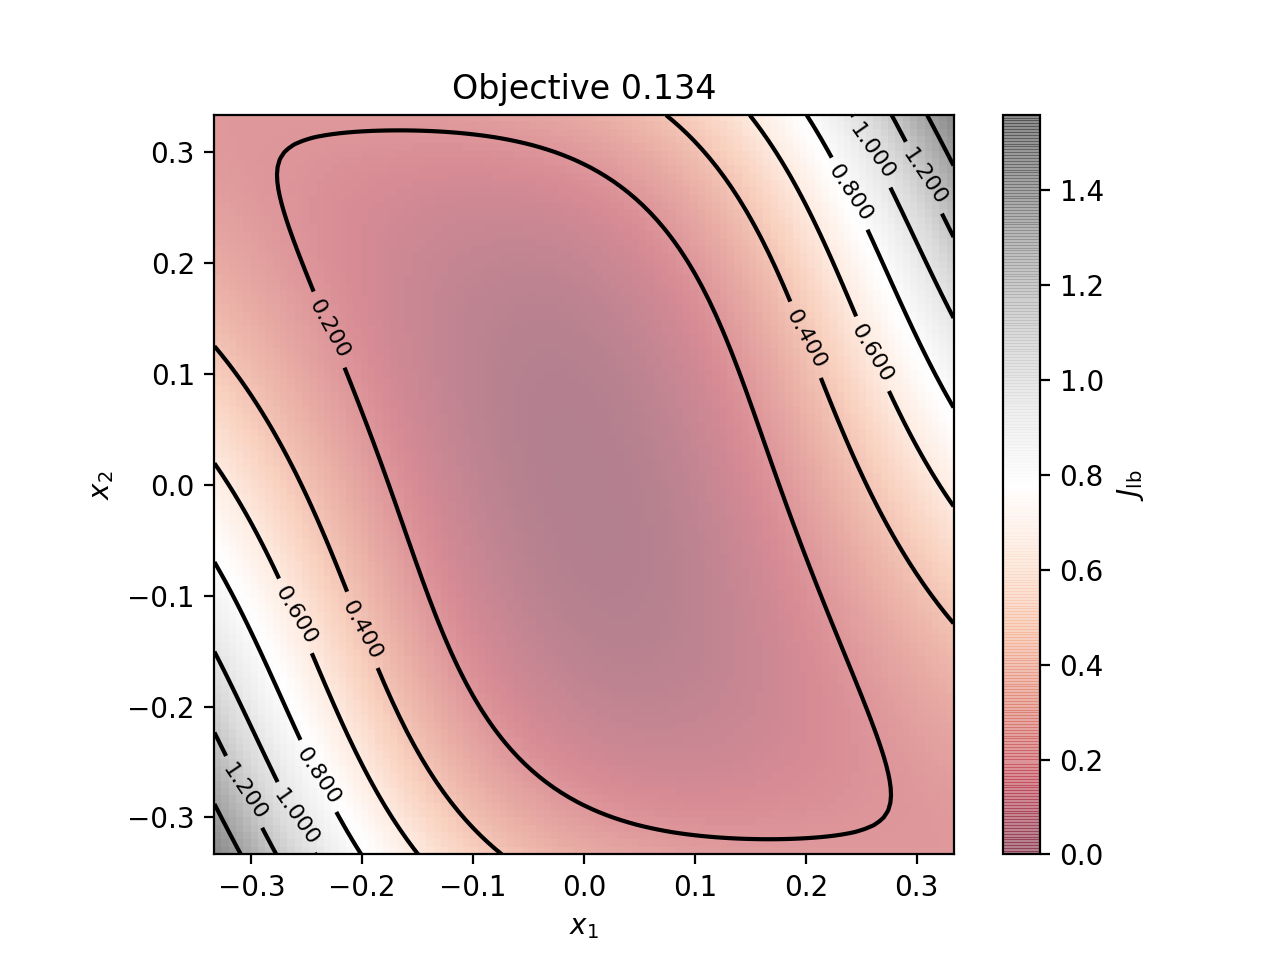

<IPython.core.display.Javascript object>


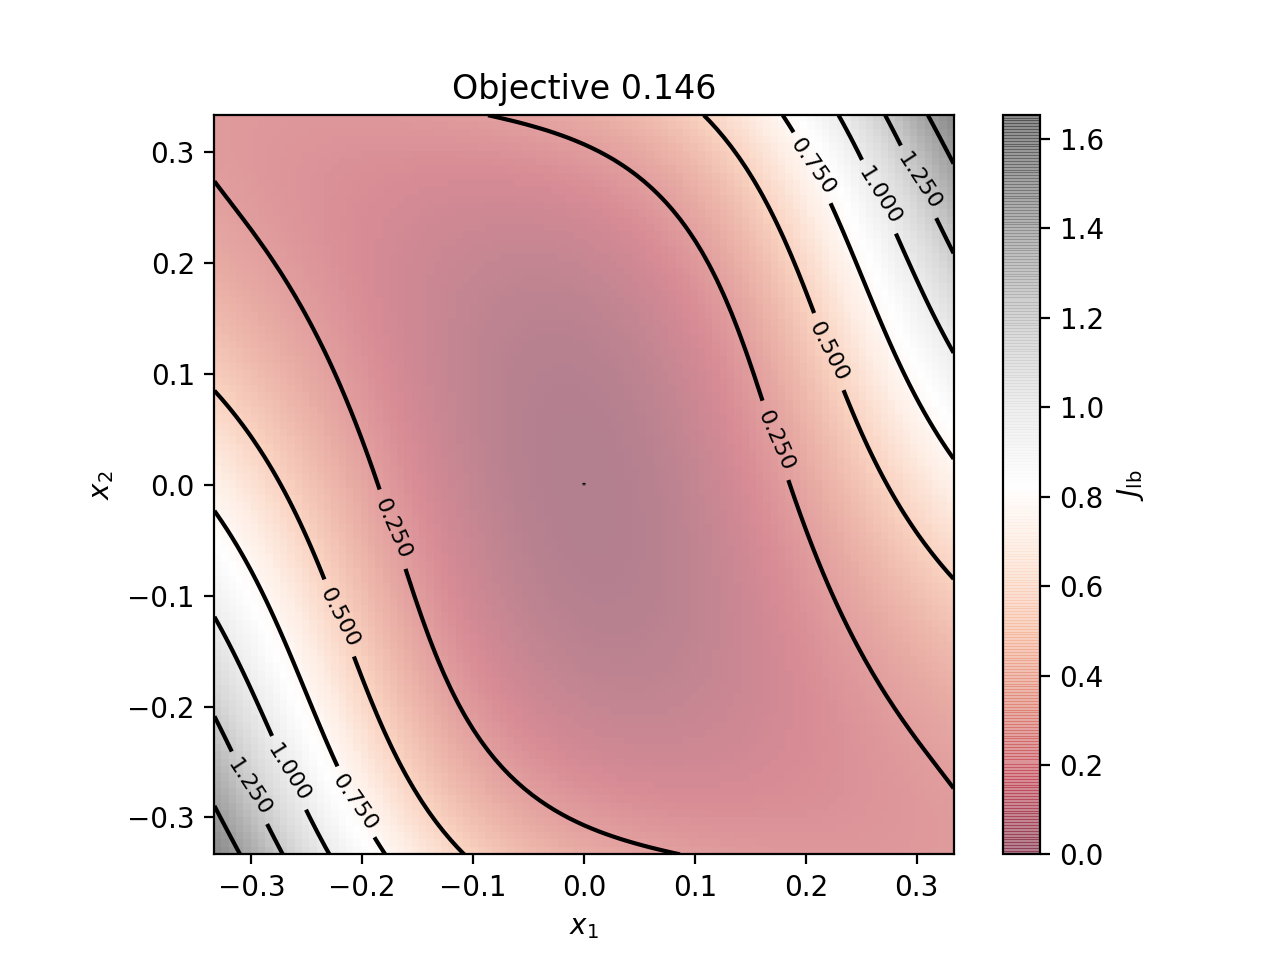

In [5]:
# Plot solution.
for d in degrees:
    plt.figure()
    level_plot(Jmon[d][0],
               - xobj, xobj,
               label=r'$J_{\mathrm{lb}}$',
               title=f'Objective {round(Jmon[d][1], 3)}')

# Lower bound on the value function (Chebyshev basis)

In [6]:
# Translate polynomial data in Chebyshev basis.
fcheb = [fi.in_chebyshev_basis() for fi in f]
lcheb = l.in_chebyshev_basis()
Xcheb = [Xi.in_chebyshev_basis() for Xi in X]
Ucheb = U.in_chebyshev_basis()

In [7]:
# Solve for increasing degree.
Jcheb = {}
for d in degrees:
    print(f'Working on SOS of degree {d}', end='\r')
    Jcheb[d] = value_function_lb(fcheb, lcheb, Xcheb, Ucheb, d)

<IPython.core.display.Javascript object>


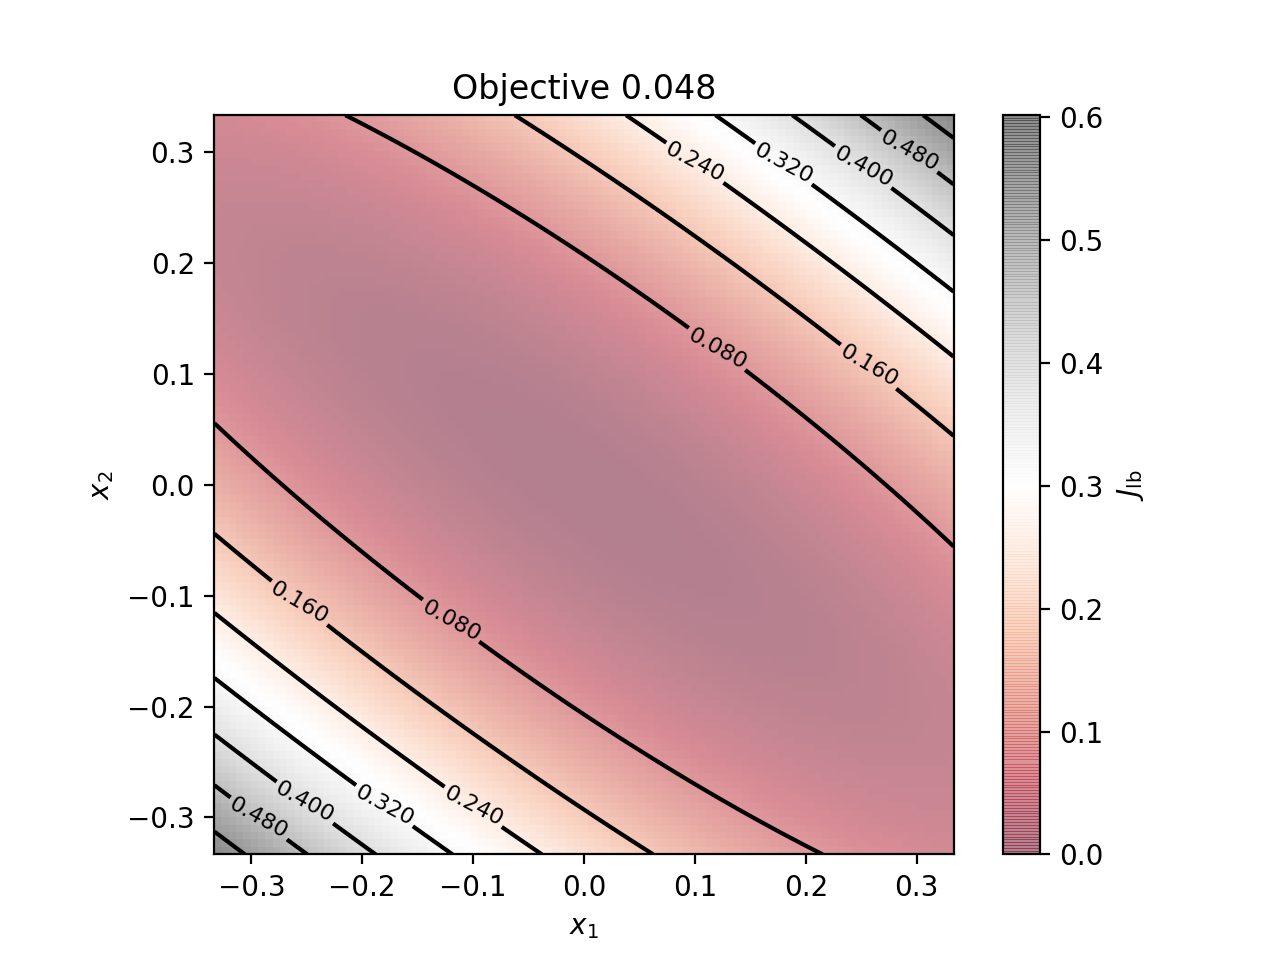

<IPython.core.display.Javascript object>


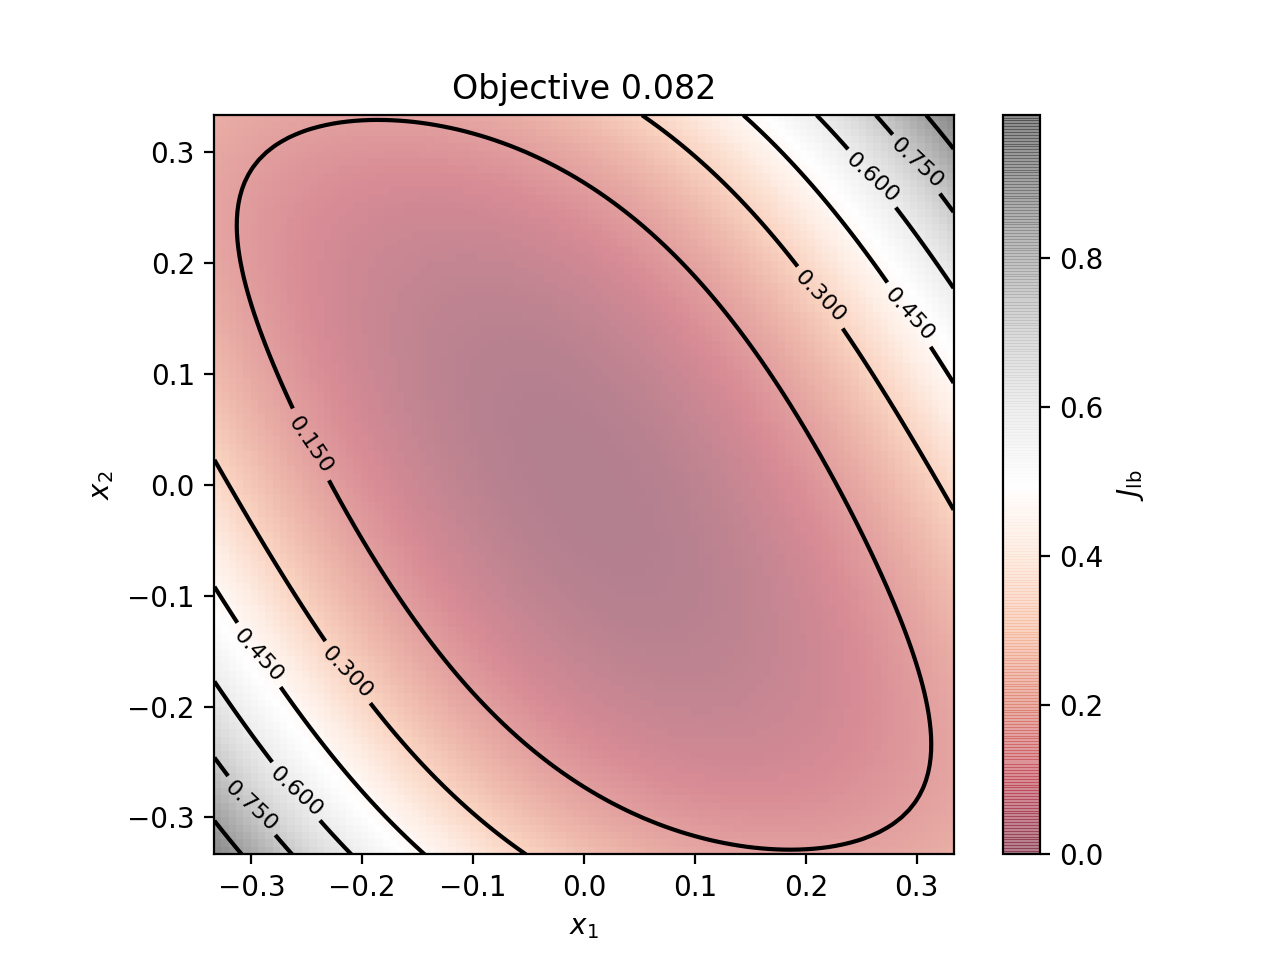

<IPython.core.display.Javascript object>


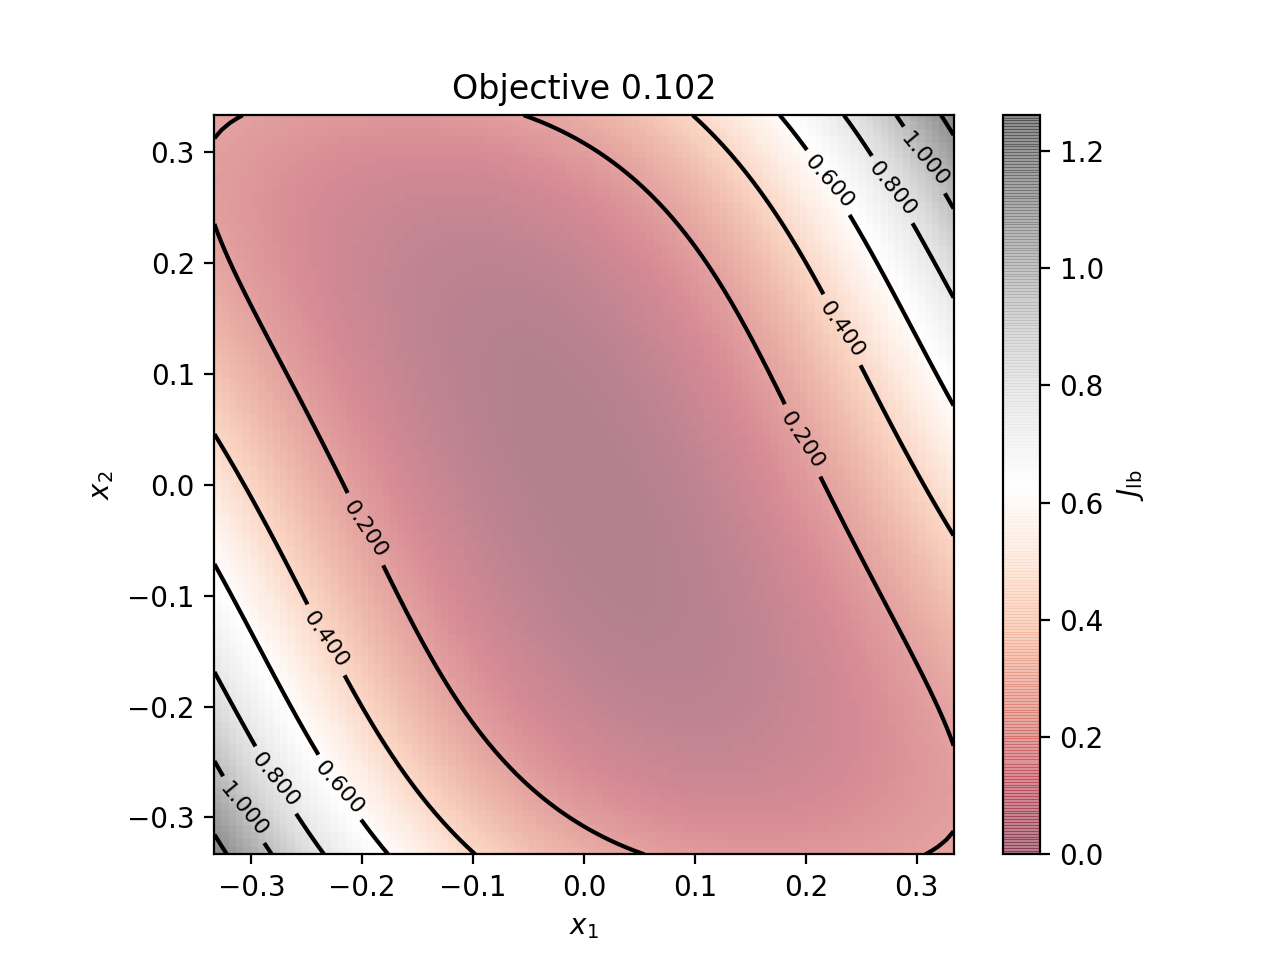

<IPython.core.display.Javascript object>


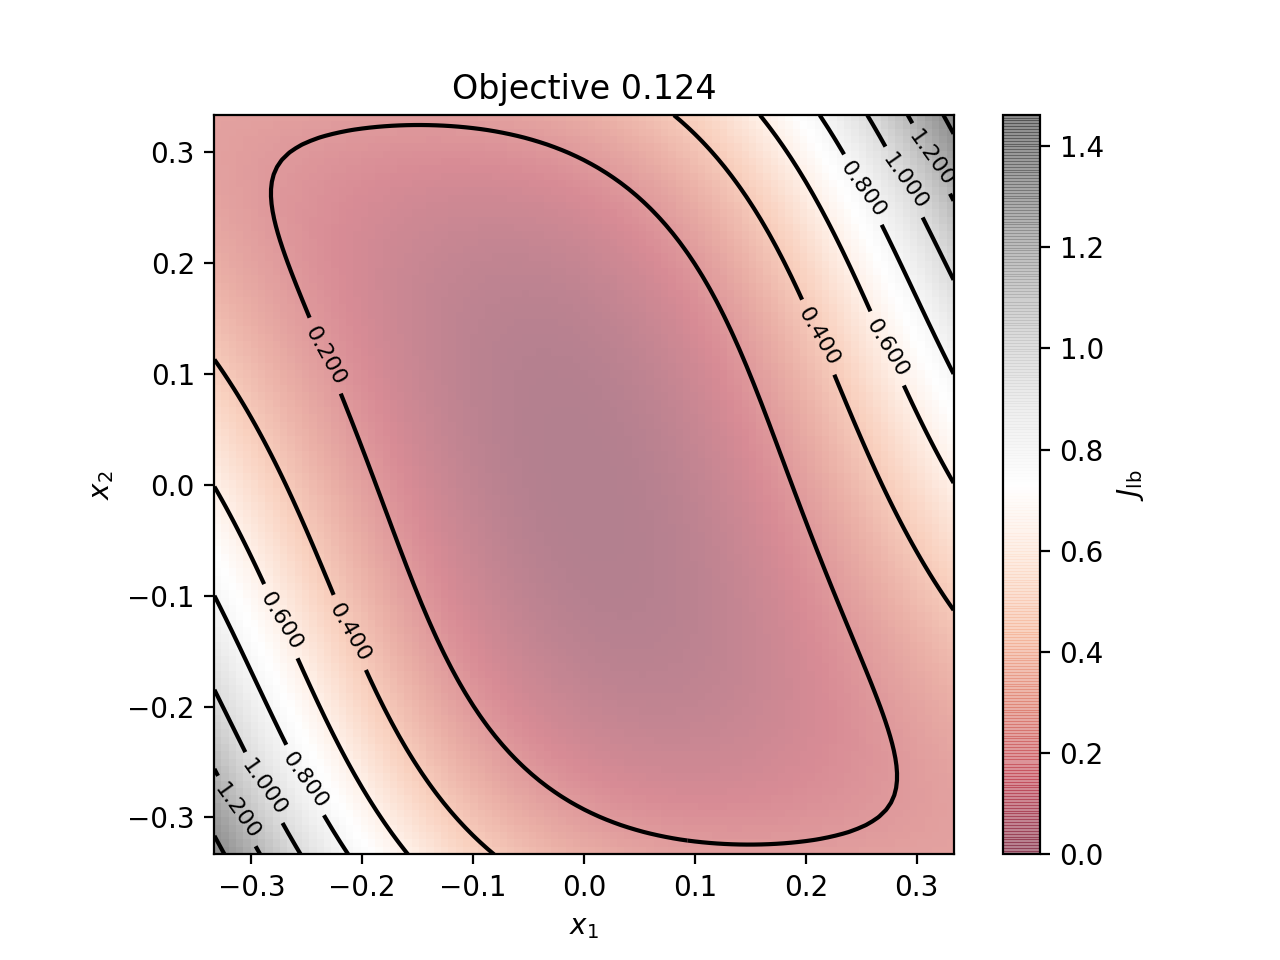

<IPython.core.display.Javascript object>


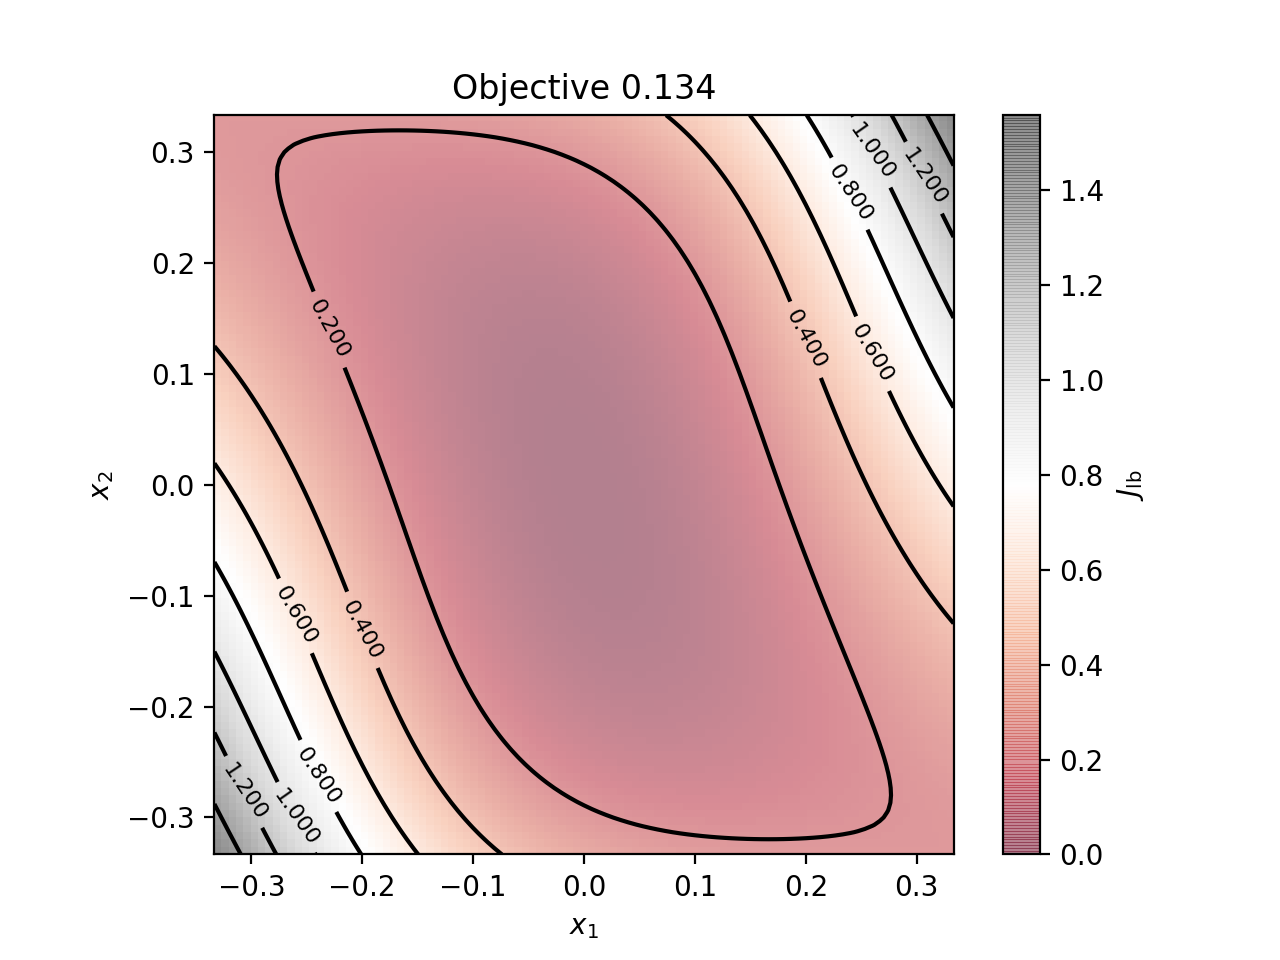

<IPython.core.display.Javascript object>


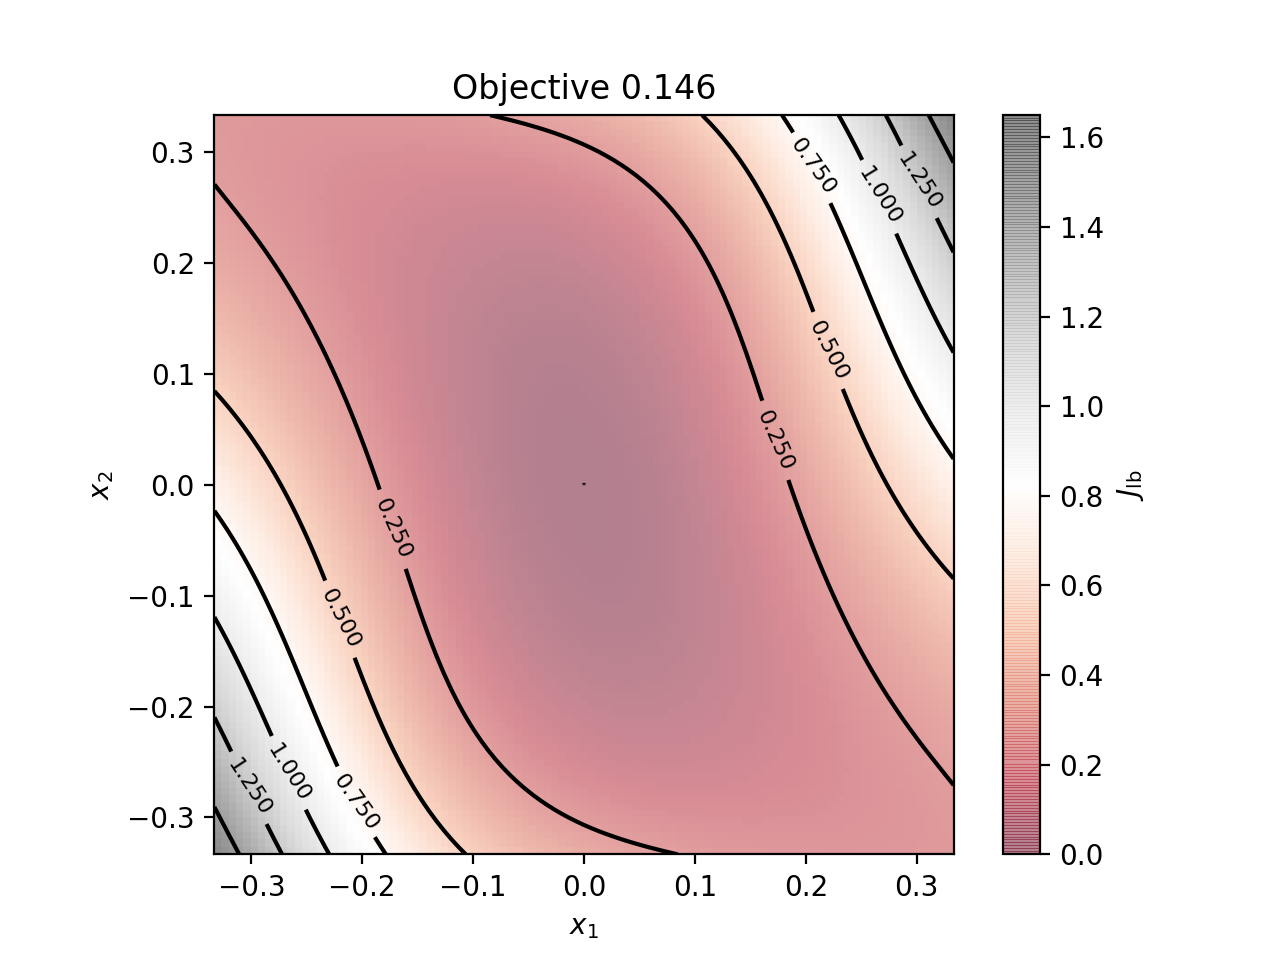

In [8]:
# Plot solution.
for d in degrees:
    plt.figure()
    level_plot(Jcheb[d][0],
               - xobj, xobj,
               label=r'$J_{\mathrm{lb}}$',
               title=f'Objective {round(Jcheb[d][1], 3)}')